# Importing Libraries

In [ ]:
#Importing all the requied libraries , which I used in this Project. 
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm
# Importe model which I had to be used in this Project.
from keras.applications.vgg16 import VGG16

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [ ]:
# That's are my model path directories 
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [ ]:
# Using condition to confirm that have all above defined directories are their or not . 
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

As a result, a csv file will be created containing the locations of the training and test images, and their associated classes, if present, so that the data can be traced easily.

In [ ]:
# Use pandas library to read csv file of training and testing data set.
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

## Converting into numerical values

1 :- Using tolist() function returns a copy of the array elements as a Python list.
2 :- Using PKL file enabless objects to be serialized to files on disk and deserialized back into the program at runtime.
3 :- At the last converts a Python object hierarchy into a byte stream written to a buffer or to a disk file.

In [ ]:

labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c3': 0, 'c6': 1, 'c8': 2, 'c1': 3, 'c5': 4, 'c7': 5, 'c4': 6, 'c9': 7, 'c0': 8, 'c2': 9}
(17462, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [ ]:
# Spliting each data train and test into two parts . 
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# Using library function ImageFile to make file or directory situable for pictures. 
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 3493/3493 [00:50<00:00, 68.50it/s]


# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG16 model
2. Using the n-1 layers of VGG16 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [ ]:
model = VGG16(include_top=False)
model.summary()

58892288/58889256 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

In [ ]:
# predicting model at both train and valid with single single animated progress bar 
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

110/110 [==============================] - 131s 1s/step


In [ ]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (13969, 2, 2, 512)
Validation shape (3493, 2, 2, 512)


In [ ]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [ ]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [ ]:
# To create a model layer-by-layer.
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# In this step I have convert python code from string form to code object. 
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

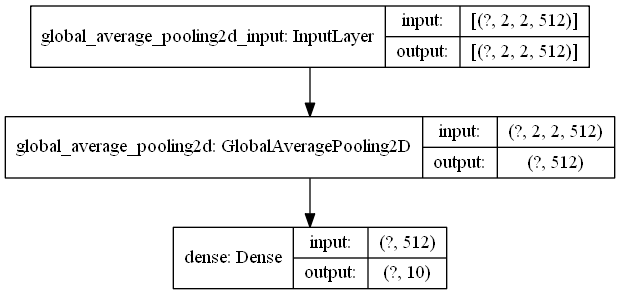

In [ ]:
plot_model(VGG16_model,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

In [ ]:
# Create a path to save the check point 
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
# Creating chekpoint to save and source control combined into a single package.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = VGG16_model.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=400, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/400
874/874 [==============================] - ETA: 0s - loss: 1.7782 - accuracy: 0.4573
Epoch 00001: val_accuracy improved from -inf to 0.59519, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16\distracted-01-0.60.hdf5
874/874 [==============================] - 2s 2ms/step - loss: 1.7782 - accuracy: 0.4573 - val_loss: 1.4332 - val_accuracy: 0.5952
Epoch 2/400
873/874 [============================>.] - ETA: 0s - loss: 1.2330 - accuracy: 0.6767
Epoch 00002: val_accuracy improved from 0.59519 to 0.68852, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16\distracted-02-0.69.hdf5
874/874 [==============================] - 1s 2ms/step - loss: 1.2329 - accuracy: 0.6767 - val_loss: 1.1138 - val_accuracy: 0.6885
Epoch 3/400
871/874 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.7489
Epoch 00003: val_accuracy improved from 0.68852 to 0.76668, saving model to C:\Users\Engr Amir\Dow

Epoch 23/400
863/874 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.9240
Epoch 00023: val_accuracy improved from 0.90753 to 0.91096, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16\distracted-23-0.91.hdf5
874/874 [==============================] - 1s 1ms/step - loss: 0.3058 - accuracy: 0.9239 - val_loss: 0.3416 - val_accuracy: 0.9110
Epoch 24/400
849/874 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.9269
Epoch 00024: val_accuracy did not improve from 0.91096
874/874 [==============================] - 1s 1ms/step - loss: 0.2984 - accuracy: 0.9266 - val_loss: 0.3348 - val_accuracy: 0.9104
Epoch 25/400
830/874 [===========================>..] - ETA: 0s - loss: 0.2915 - accuracy: 0.9281
Epoch 00025: val_accuracy improved from 0.91096 to 0.91469, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16\distracted-25-0.91.hdf5
874/874 [============================

Epoch 49/400
870/874 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9476
Epoch 00049: val_accuracy did not improve from 0.92728
874/874 [==============================] - 1s 1ms/step - loss: 0.2037 - accuracy: 0.9476 - val_loss: 0.2534 - val_accuracy: 0.9264
Epoch 50/400
830/874 [===========================>..] - ETA: 0s - loss: 0.2029 - accuracy: 0.9479
Epoch 00050: val_accuracy did not improve from 0.92728
874/874 [==============================] - 1s 1ms/step - loss: 0.2017 - accuracy: 0.9481 - val_loss: 0.2536 - val_accuracy: 0.9244
Epoch 51/400
843/874 [===========================>..] - ETA: 0s - loss: 0.1989 - accuracy: 0.9486
Epoch 00051: val_accuracy did not improve from 0.92728
874/874 [==============================] - 1s 1ms/step - loss: 0.2001 - accuracy: 0.9481 - val_loss: 0.2505 - val_accuracy: 0.9230
Epoch 52/400
834/874 [===========================>..] - ETA: 0s - loss: 0.1976 - accuracy: 0.9499
Epoch 00052: val_accuracy did not improve from 0.9

Epoch 76/400
870/874 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9560
Epoch 00076: val_accuracy did not improve from 0.93330
874/874 [==============================] - 1s 1ms/step - loss: 0.1649 - accuracy: 0.9559 - val_loss: 0.2250 - val_accuracy: 0.9293
Epoch 77/400
836/874 [===========================>..] - ETA: 0s - loss: 0.1635 - accuracy: 0.9571
Epoch 00077: val_accuracy did not improve from 0.93330
874/874 [==============================] - 1s 1ms/step - loss: 0.1641 - accuracy: 0.9570 - val_loss: 0.2213 - val_accuracy: 0.9304
Epoch 78/400
828/874 [===========================>..] - ETA: 0s - loss: 0.1652 - accuracy: 0.9558
Epoch 00078: val_accuracy did not improve from 0.93330
874/874 [==============================] - 1s 1ms/step - loss: 0.1634 - accuracy: 0.9563 - val_loss: 0.2197 - val_accuracy: 0.9310
Epoch 79/400
854/874 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9578
Epoch 00079: val_accuracy did not improve from 0.9

Epoch 00104: val_accuracy did not improve from 0.93444
874/874 [==============================] - 1s 1ms/step - loss: 0.1447 - accuracy: 0.9613 - val_loss: 0.2086 - val_accuracy: 0.9342
Epoch 105/400
865/874 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9621
Epoch 00105: val_accuracy did not improve from 0.93444
874/874 [==============================] - 1s 1ms/step - loss: 0.1437 - accuracy: 0.9623 - val_loss: 0.2087 - val_accuracy: 0.9313
Epoch 106/400
820/874 [===========================>..] - ETA: 0s - loss: 0.1419 - accuracy: 0.9627
Epoch 00106: val_accuracy did not improve from 0.93444
874/874 [==============================] - 1s 1ms/step - loss: 0.1431 - accuracy: 0.9621 - val_loss: 0.2137 - val_accuracy: 0.9330
Epoch 107/400
840/874 [===========================>..] - ETA: 0s - loss: 0.1423 - accuracy: 0.9617
Epoch 00107: val_accuracy did not improve from 0.93444
874/874 [==============================] - 1s 1ms/step - loss: 0.1421 - accuracy: 0.9619 -

Epoch 132/400
867/874 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9658
Epoch 00132: val_accuracy did not improve from 0.93673
874/874 [==============================] - 1s 1ms/step - loss: 0.1300 - accuracy: 0.9658 - val_loss: 0.2134 - val_accuracy: 0.9313
Epoch 133/400
849/874 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9644
Epoch 00133: val_accuracy did not improve from 0.93673
874/874 [==============================] - 1s 1ms/step - loss: 0.1308 - accuracy: 0.9645 - val_loss: 0.2008 - val_accuracy: 0.9362
Epoch 134/400
860/874 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9655
Epoch 00134: val_accuracy did not improve from 0.93673
874/874 [==============================] - 1s 1ms/step - loss: 0.1308 - accuracy: 0.9651 - val_loss: 0.2031 - val_accuracy: 0.9364
Epoch 135/400
830/874 [===========================>..] - ETA: 0s - loss: 0.1309 - accuracy: 0.9643
Epoch 00135: val_accuracy did not improve from

Epoch 00159: val_accuracy did not improve from 0.93788
874/874 [==============================] - 1s 1ms/step - loss: 0.1227 - accuracy: 0.9657 - val_loss: 0.1995 - val_accuracy: 0.9362
Epoch 160/400
827/874 [===========================>..] - ETA: 0s - loss: 0.1212 - accuracy: 0.9664
Epoch 00160: val_accuracy did not improve from 0.93788
874/874 [==============================] - 1s 1ms/step - loss: 0.1221 - accuracy: 0.9667 - val_loss: 0.2008 - val_accuracy: 0.9350
Epoch 161/400
860/874 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9669
Epoch 00161: val_accuracy did not improve from 0.93788
874/874 [==============================] - 1s 1ms/step - loss: 0.1222 - accuracy: 0.9671 - val_loss: 0.1996 - val_accuracy: 0.9353
Epoch 162/400
821/874 [===========================>..] - ETA: 0s - loss: 0.1221 - accuracy: 0.9673
Epoch 00162: val_accuracy did not improve from 0.93788
874/874 [==============================] - 1s 1ms/step - loss: 0.1216 - accuracy: 0.9673 -

Epoch 188/400
835/874 [===========================>..] - ETA: 0s - loss: 0.1148 - accuracy: 0.9698
Epoch 00188: val_accuracy did not improve from 0.93845
874/874 [==============================] - 1s 1ms/step - loss: 0.1154 - accuracy: 0.9696 - val_loss: 0.2022 - val_accuracy: 0.9356
Epoch 189/400
839/874 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9701
Epoch 00189: val_accuracy did not improve from 0.93845
874/874 [==============================] - 1s 1ms/step - loss: 0.1152 - accuracy: 0.9701 - val_loss: 0.2032 - val_accuracy: 0.9362
Epoch 190/400
860/874 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9693
Epoch 00190: val_accuracy did not improve from 0.93845
874/874 [==============================] - 1s 1ms/step - loss: 0.1157 - accuracy: 0.9693 - val_loss: 0.2014 - val_accuracy: 0.9382
Epoch 191/400
823/874 [===========================>..] - ETA: 0s - loss: 0.1157 - accuracy: 0.9689
Epoch 00191: val_accuracy did not improve from

Epoch 216/400
820/874 [===========================>..] - ETA: 0s - loss: 0.1111 - accuracy: 0.9703
Epoch 00216: val_accuracy did not improve from 0.93988
874/874 [==============================] - 1s 1ms/step - loss: 0.1107 - accuracy: 0.9702 - val_loss: 0.1996 - val_accuracy: 0.9393
Epoch 217/400
852/874 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9707
Epoch 00217: val_accuracy did not improve from 0.93988
874/874 [==============================] - 1s 1ms/step - loss: 0.1099 - accuracy: 0.9708 - val_loss: 0.2043 - val_accuracy: 0.9373
Epoch 218/400
867/874 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9709
Epoch 00218: val_accuracy did not improve from 0.93988
874/874 [==============================] - 1s 1ms/step - loss: 0.1101 - accuracy: 0.9708 - val_loss: 0.2006 - val_accuracy: 0.9396
Epoch 219/400
816/874 [===========================>..] - ETA: 0s - loss: 0.1080 - accuracy: 0.9709
Epoch 00219: val_accuracy did not improve from

830/874 [===========================>..] - ETA: 0s - loss: 0.1075 - accuracy: 0.9709
Epoch 00244: val_accuracy did not improve from 0.94017
874/874 [==============================] - 1s 1ms/step - loss: 0.1067 - accuracy: 0.9710 - val_loss: 0.2045 - val_accuracy: 0.9387
Epoch 245/400
846/874 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9718
Epoch 00245: val_accuracy did not improve from 0.94017
874/874 [==============================] - 1s 1ms/step - loss: 0.1064 - accuracy: 0.9719 - val_loss: 0.2047 - val_accuracy: 0.9367
Epoch 246/400
872/874 [============================>.] - ETA: 0s - loss: 0.1062 - accuracy: 0.9721
Epoch 00246: val_accuracy did not improve from 0.94017
874/874 [==============================] - 1s 1ms/step - loss: 0.1063 - accuracy: 0.9721 - val_loss: 0.2025 - val_accuracy: 0.9390
Epoch 247/400
849/874 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9722
Epoch 00247: val_accuracy did not improve from 0.94017
874/8

Epoch 273/400
827/874 [===========================>..] - ETA: 0s - loss: 0.1038 - accuracy: 0.9725
Epoch 00273: val_accuracy did not improve from 0.94045
874/874 [==============================] - 1s 1ms/step - loss: 0.1031 - accuracy: 0.9728 - val_loss: 0.2059 - val_accuracy: 0.9390
Epoch 274/400
829/874 [===========================>..] - ETA: 0s - loss: 0.1033 - accuracy: 0.9728
Epoch 00274: val_accuracy did not improve from 0.94045
874/874 [==============================] - 1s 1ms/step - loss: 0.1036 - accuracy: 0.9724 - val_loss: 0.2067 - val_accuracy: 0.9367
Epoch 275/400
839/874 [===========================>..] - ETA: 0s - loss: 0.1031 - accuracy: 0.9724
Epoch 00275: val_accuracy did not improve from 0.94045
874/874 [==============================] - 1s 1ms/step - loss: 0.1033 - accuracy: 0.9721 - val_loss: 0.2080 - val_accuracy: 0.9393
Epoch 276/400
831/874 [===========================>..] - ETA: 0s - loss: 0.1023 - accuracy: 0.9722
Epoch 00276: val_accuracy did not improve from

Epoch 301/400
867/874 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9724
Epoch 00301: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.1005 - accuracy: 0.9724 - val_loss: 0.2145 - val_accuracy: 0.9356
Epoch 302/400
831/874 [===========================>..] - ETA: 0s - loss: 0.1015 - accuracy: 0.9735
Epoch 00302: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.1005 - accuracy: 0.9738 - val_loss: 0.2139 - val_accuracy: 0.9362
Epoch 303/400
836/874 [===========================>..] - ETA: 0s - loss: 0.1000 - accuracy: 0.9735
Epoch 00303: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.1006 - accuracy: 0.9730 - val_loss: 0.2113 - val_accuracy: 0.9390
Epoch 304/400
845/874 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9733
Epoch 00304: val_accuracy did not improve from

Epoch 330/400
844/874 [===========================>..] - ETA: 0s - loss: 0.0994 - accuracy: 0.9732
Epoch 00330: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0987 - accuracy: 0.9734 - val_loss: 0.2141 - val_accuracy: 0.9399
Epoch 331/400
843/874 [===========================>..] - ETA: 0s - loss: 0.0988 - accuracy: 0.9729
Epoch 00331: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0986 - accuracy: 0.9729 - val_loss: 0.2123 - val_accuracy: 0.9393
Epoch 332/400
841/874 [===========================>..] - ETA: 0s - loss: 0.0989 - accuracy: 0.9738
Epoch 00332: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0993 - accuracy: 0.9738 - val_loss: 0.2169 - val_accuracy: 0.9384
Epoch 333/400
848/874 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9744
Epoch 00333: val_accuracy did not improve from

Epoch 359/400
846/874 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9750
Epoch 00359: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0970 - accuracy: 0.9749 - val_loss: 0.2212 - val_accuracy: 0.9390
Epoch 360/400
857/874 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9740
Epoch 00360: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0968 - accuracy: 0.9741 - val_loss: 0.2185 - val_accuracy: 0.9364
Epoch 361/400
844/874 [===========================>..] - ETA: 0s - loss: 0.0977 - accuracy: 0.9748
Epoch 00361: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0972 - accuracy: 0.9748 - val_loss: 0.2182 - val_accuracy: 0.9382
Epoch 362/400
830/874 [===========================>..] - ETA: 0s - loss: 0.0966 - accuracy: 0.9745
Epoch 00362: val_accuracy did not improve from

Epoch 388/400
872/874 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9755
Epoch 00388: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0961 - accuracy: 0.9754 - val_loss: 0.2264 - val_accuracy: 0.9376
Epoch 389/400
865/874 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9757
Epoch 00389: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0960 - accuracy: 0.9757 - val_loss: 0.2233 - val_accuracy: 0.9364
Epoch 390/400
851/874 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9752
Epoch 00390: val_accuracy did not improve from 0.94102
874/874 [==============================] - 1s 1ms/step - loss: 0.0948 - accuracy: 0.9752 - val_loss: 0.2247 - val_accuracy: 0.9370
Epoch 391/400
841/874 [===========================>..] - ETA: 0s - loss: 0.0942 - accuracy: 0.9747
Epoch 00391: val_accuracy did not improve from

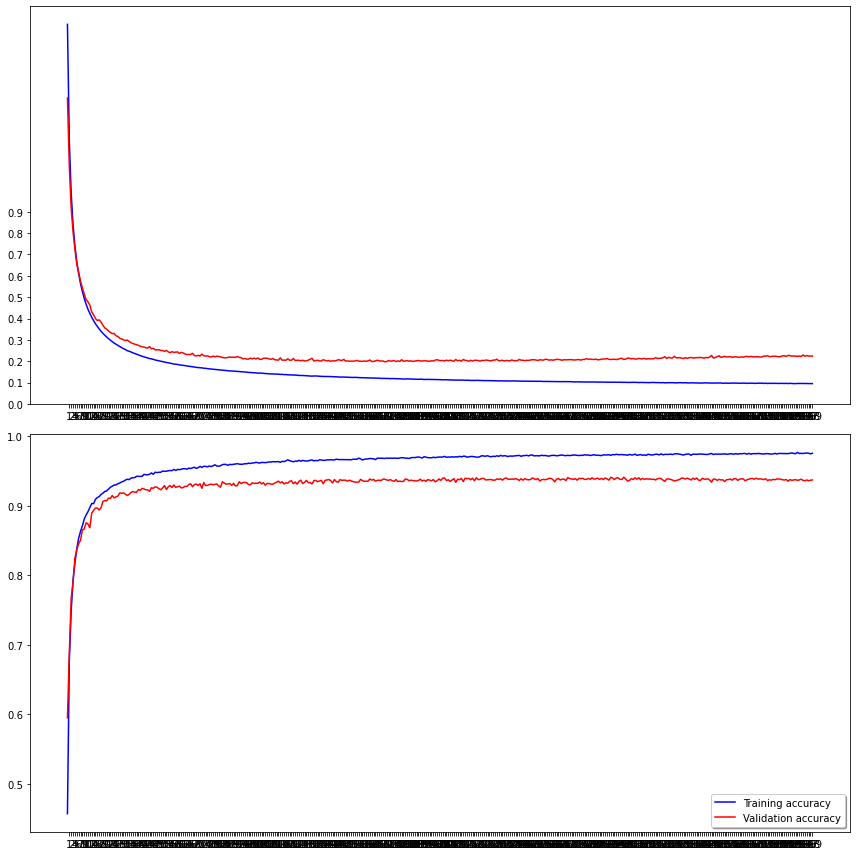

In [ ]:
# displayed comparatively result of train and validation data 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG16_model.predict(valid_vgg16,verbose=1)

110/110 [==============================] - 0s 770us/step


## Confusion Matrix

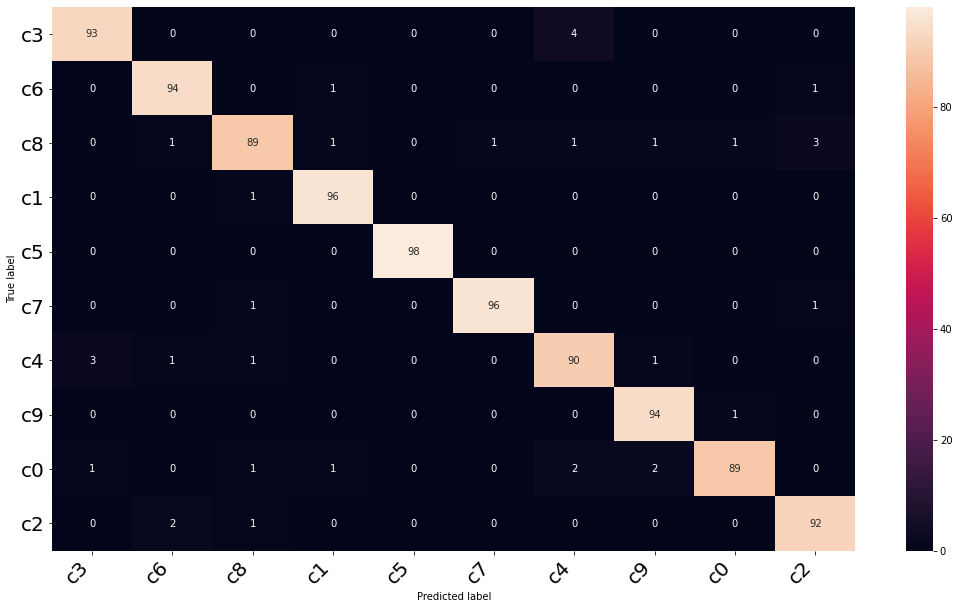

In [ ]:
# Pridicting the accuracy of model by ploting heatmap for True and predicted labels 
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [ ]:
# Indexing the greater class from row with axis = 1 
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
# Indexing the greater number from row with axis = 1 
ytest = np.argmax(ytest,axis=1)

                 **MODEL PERFORMANCE BASED UPON**
1 :- positive prediction         
2 :- actual positive value

In [ ]:
# Checked model accuracy out of actual positive prediction and value
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.937017
Precision: 0.937256
Recall: 0.937017
F1 score: 0.937033
